# Mat 258A HW 8
Consider the LASSO problem that you solved last week!!

$$
\min_{x \in \mathbb{R}^n} \; \frac{1}{2} \|Ax - b\|_2^2 + \tau \|x\|_1,
$$

where $\tau > 0$ is a weighting parameter, $A \in \mathbb{R}^{m \times n}$, $b
\in \mathbb{R}^m$ are given data. Use the following Matlab code to generate the
data:

```
    m = 300; n = 500; s = 2;
    A = randn(m,n);
    xs = zeros(n,1); picks = randperm(n); 
    xs(picks(1:s)) = 100*rand(s,1);
    b = A*xs;
    tau = 1;
```

Note that $xs$ is the true solution that you want to find. Also this set of data
is easier than the one from last week. So you should be able to achieve the
targeted accuracy.  Write codes as requested below. For all codes, choose $x = 0$
as the starting point, and terminate your codes when your iterate $x^k$ satisfies
$$
\frac{ \lVert x^k - xs \rVert_2}{\lVert xs \rVert_2} < \varepsilon
$$
for $\varepsilon = 10^{-3}$.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.seterr(all='ignore')

m = 300
n = 500
s = 2

A = np.random.standard_normal((m, n))
xs = np.zeros((n, 1))
picks = np.random.choice(n, s, replace=False)
xs[picks] = 100 * np.random.standard_normal((s, 1))
b = A @ xs


### Reusable plotting code

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

def plot_runs(runs: List[Dict],
              title: str = "A Title for the Plots"):
    """
    Draw two figures:  cumulative CPU time and objective error
    for the given runs.

    Parameters
    ----------
    runs : list of dict
        Each element is exactly the dictionary returned by `sg_method_solve`.
        Design matrix and response vector (needed for objective values).
    """
    figure_size = (10, 6)

    # Figure 1: objective value relative error vs cumulative CPU time
    plt.figure(figsize=figure_size)
    for run in runs:
        method, step_method, times, f_rel_err = run["method"], run["step_method"], run["times"], run["f_rel_err"]
        plt.semilogy(times, f_rel_err,
                     label=rf"$method: {method}, step: {step_method}$")
    plt.xlabel("Time (s)")
    plt.ylabel(r"$(f(x_k)-f(xs))/f(xs)$")
    plt.title(fr"{title}: obj rel error vs time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 2: objective value relative error vs iterations
    plt.figure(figsize=figure_size)
    for run in runs:
        method, step_method, f_rel_err = run["method"], run["step_method"], run["f_rel_err"]
        plt.semilogy(np.arange(len(f_rel_err)), f_rel_err,
                     label=rf"$method: {method}, step: {step_method}$")
    plt.xlabel("Iteration $k$")
    plt.ylabel(r"$(f(x_k)-f(xs))/f(xs)$")
    plt.title(fr"{title}: obj rel error vs iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figure 3: relative error vs cumulative CPU time
    # plt.figure(figsize=figure_size)
    # for run in runs:
    #     method, step_method, times, x_rel_err = run["method"], run["step_method"], run["times"], run["x_rel_error"]
    #     plt.semilogy(times, x_rel_err,
    #                  label=rf"$method: {method}, step: {step_method}$")
    # plt.xlabel("Time (s)")
    # plt.ylabel("|xk - xs|/|xs| Relative Error")
    # plt.title(fr"{title}: xk rel error vs time")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # Figure 4: relative error vs iterations
    # plt.figure(figsize=figure_size)
    # for run in runs:
    #     method, step_method, x_rel_err = run["method"], run["step_method"], run["x_rel_error"]
    #     plt.semilogy(np.arange(len(x_rel_err)), x_rel_err,
    #                  label=rf"$method: {method}, step: {step_method}$")
    # plt.xlabel("Iteration $k$")
    # plt.ylabel("|xk - xs|/|xs| Relative Error")
    # plt.title(fr"{title}: xk rel error vs iteration")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

## ISTA + FISTA Method
Run the proximal gradient method (ISTA) you implemented last week to solve the Lasso problem. Try both fixed
step size, and backtracking line search.

In [13]:
from enum import Enum

def tol_check(x_k, xs, tol, eps=1e-14):
    norm_xs = np.linalg.norm(xs)
    if norm_xs < 1e-14:
        error = np.linalg.norm(x_k)
    else:
        error = np.linalg.norm(x_k - xs) / norm_xs
    return error < tol, error

def soft_threshold(u, t): 
    return np.sign(u) * np.maximum(np.abs(u) - t, 0)

def lasso_obj(A: np.ndarray, b: np.ndarray, x: np.ndarray, tau: float) -> float:
    return (1 / 2) * np.linalg.norm(A @ x - b)**2 + tau * np.linalg.norm(x, 1)

def ls_obj(A, x, b):
    return (1/2) * np.linalg.norm(A @ x - b) ** 2

def ls_grad(A, x, b):
    return np.transpose(A) @ (A @ x - b)

def backtracking_check(g, grad_g, Gt, g_Gt, t):
    lhs = g_Gt
    rhs = g - t * np.transpose(grad_g) @ Gt + (t / 2) * np.linalg.norm(Gt) ** 2
    return lhs < rhs

def backtracking_search(A, b, x, tau, t_0, beta=0.6, max_iter=100):
    """Compute the step size via backtracking"""
    t = t_0
    g = ls_obj(A, x, b) 
    grad_g = ls_grad(A, x, b)
    
    for _ in range(max_iter):
        Gt = (1 / t) * (x - soft_threshold(x - t * grad_g, tau * t))
        g_Gt = ls_obj(A, x - t * Gt, b)
        
        if backtracking_check(g, grad_g, Gt, g_Gt, t):
            return t
            
        t = beta * t
    
    # Return last t if max iterations reached
    return t

class IstaMethodEnum(Enum):
    STANDARD = "ISTA"
    FAST = "FISTA"

class StepMethodEnum(Enum):
    FIXED = "fixed"
    BACKTRACKING = "backtracking"

def ista_method_solve(A, b, x0, xs, tau=1, eps=1e-6, max_iter=100000,
                      method: IstaMethodEnum = IstaMethodEnum.STANDARD,
                      step_method: StepMethodEnum = StepMethodEnum.FIXED):
    x_prev = x0.copy()
    x = x0.copy()

    x_ks = []
    times = []

    time_s = time.time()

    t_0 = 1
    t = t_0

    if step_method == StepMethodEnum.FIXED:
        L = np.linalg.norm(A, 2)**2
        t = 1/L

    for k in range(1, max_iter + 1):
        if method == IstaMethodEnum.STANDARD:
            y = x
        if method == IstaMethodEnum.FAST:
            y = x + (k - 2) / (k + 1) * (x - x_prev)

        grad = ls_grad(A, y, b)

        if step_method == StepMethodEnum.BACKTRACKING:
            t = backtracking_search(A, b, y, tau, t_0)

        x_prev = x
        x = soft_threshold(y - t * grad, tau * t)
        
        done, error = tol_check(x, xs, eps)
        x_ks.append(x)
        times.append(time.time() - time_s)

        if done:
            elapsed_time = time.time() - time_s
            print(f"[eps={eps:.0e}] Converged in {k} iterations ({elapsed_time:.2f} s). Final error: {error:.2e}")
            break
    else: 
        print(f"[eps={eps:.0e}] Did not converge in {max_iter} iterations.")

    x_rel_err = [np.linalg.norm(xk - xs) / np.linalg.norm(xs) for xk in x_ks]
    f_xks = [lasso_obj(A, b, xk, tau) for xk in x_ks]
    f_err = [lasso_obj(A, b, xk, tau) - lasso_obj(A, b, xs, tau) for xk in x_ks]
    f_rel_err = [fe / lasso_obj(A, b, xs, tau) for fe in f_err]
    
    return {
        "x_ks": x_ks,
        "x_rel_error": x_rel_err,
        "f_xks": f_xks,
        "f_rel_err": f_rel_err,
        "times": times,
        "iters": k,
        "tau": tau,
        "eps": eps, 
        "method": method.value,
        "step_method": step_method.value,
    }

In [ ]:
def run_ista_grid_and_plot(A: np.ndarray,
                      b: np.ndarray,
                      x0: np.ndarray,
                      xs: np.ndarray,
                      params: List[Tuple[IstaMethodEnum, StepMethodEnum]],
                      tau: float = 1,
                      eps: float = 1e-3,
                      max_iter: int = 1000000):
    all_runs = []
    for (ista_method, step_method) in params:
            result = ista_method_solve(A, b, x0, xs,
                                     tau=tau,
                                     eps=eps,
                                     max_iter=max_iter,
                                     method=ista_method,
                                     step_method=step_method
                                )
            all_runs.append(result)
    plot_runs(all_runs, fr"$\tau$={tau:.1f}, $\varepsilon$={eps:.0e}")

x0 = np.zeros((n, 1))

tau = 1
eps = 1e-3
params = [
          (IstaMethodEnum.STANDARD, StepMethodEnum.FIXED),
          (IstaMethodEnum.STANDARD, StepMethodEnum.BACKTRACKING),
          (IstaMethodEnum.FAST, StepMethodEnum.FIXED),
          (IstaMethodEnum.FAST, StepMethodEnum.BACKTRACKING)
         ]
run_ista_grid_and_plot(A, b, x0, xs, params, tau, eps)

## Analysis and Comparison
Answer these two questions:
<ol type="a">
  <li>When you use fixed step size for both ISTA and FISTA, is FISTA significantly faster than
ISTA? Support your conclusion by figures/experiments.</li>
  <li>When you use backtracking line search for both ISTA and FISTA, is FISTA significantly faster
than ISTA? Support your conclusion by figures/experiments.</li>
</ol>

### Question A
With fixed step sizes, FISTA is seen to be significantly faster than ISTA. From the plot of objective function relative error vs time, the difference is around .02 seconds for FISTA with fixed size vs .027 for ISTA. FISTA also takes significantly fewer iterations to converge. The step fixed step sizes used in the code are based on the theoretical results based on the 2-norm of the matrix (largest singular value):
$$
L = \lVert A \rVert_2^2, \, t = 1/L
$$

[eps=1e-03] Converged in 16426 iterations (0.27 s). Final error: 9.90e-04
[eps=1e-03] Converged in 821 iterations (0.02 s). Final error: 5.08e-04


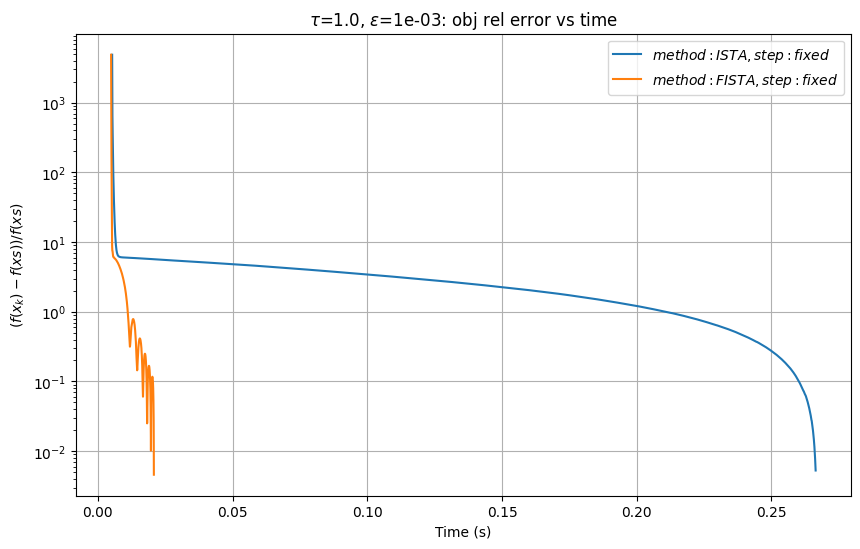

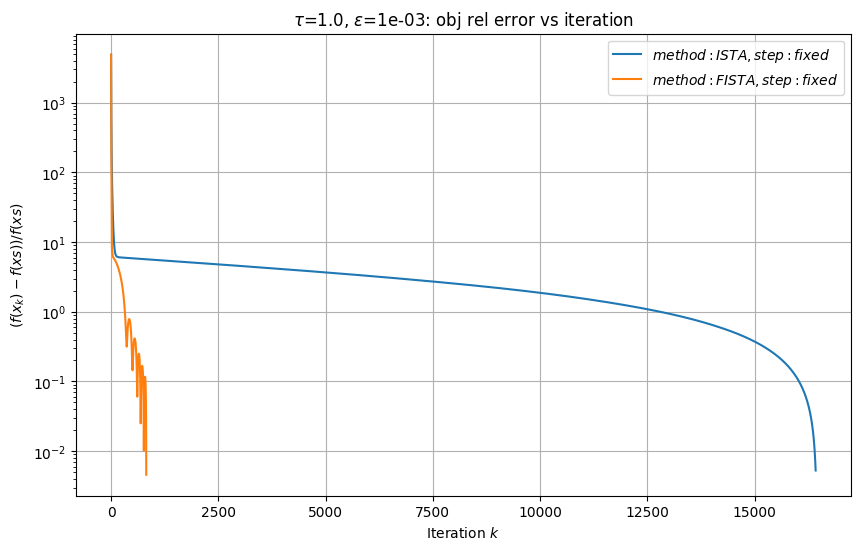

In [ ]:
x0 = np.zeros((n, 1))

tau = 1
eps = 1e-3
params = [
          (IstaMethodEnum.STANDARD, StepMethodEnum.FIXED),
          (IstaMethodEnum.FAST, StepMethodEnum.FIXED),
         ]
run_ista_grid_and_plot(A, b, x0, xs, params, tau, eps)

### Question B
FISTA continues to outperform ISTA when using backtracking. For the plots below, the initial step size for backtracking was set to 1 with a value of $\beta = 0.6$ for backtracking.

Based on the times, I get the following relative ordering of performance: FISTA fixed < FISTA backtracking < ISTA fixed < ISTA backtracking

[eps=1e-03] Converged in 2607 iterations (0.63 s). Final error: 9.94e-04
[eps=1e-03] Converged in 616 iterations (0.16 s). Final error: 7.06e-04


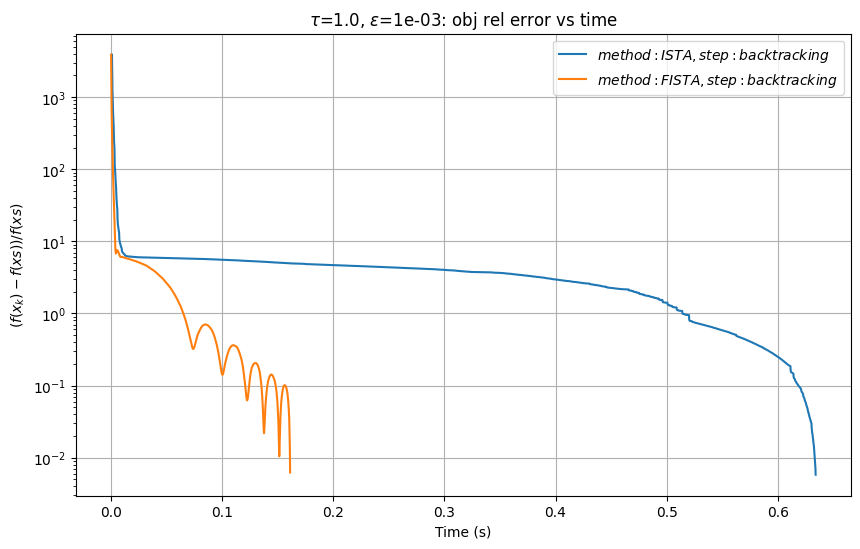

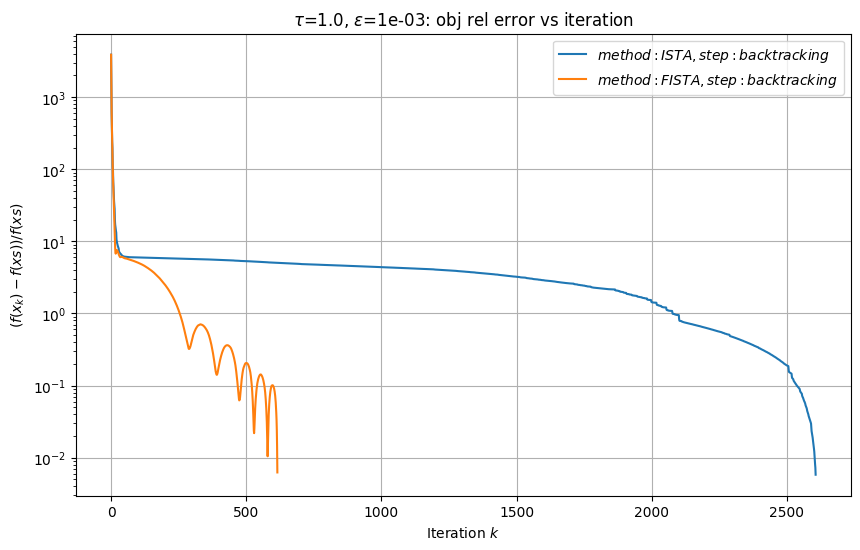

In [17]:
x0 = np.zeros((n, 1))

tau = 1
eps = 1e-3
params = [
          (IstaMethodEnum.STANDARD, StepMethodEnum.BACKTRACKING),
          (IstaMethodEnum.FAST, StepMethodEnum.BACKTRACKING),
         ]
run_ista_grid_and_plot(A, b, x0, xs, params, tau, eps)

### All in one plot
Plotting all four variants on the same plot shows the relative ordering of performance visually.

Note that the backtracking variants use less iterations than fixed step size, but the wall time is higher than their counterparts.

[eps=1e-03] Converged in 16426 iterations (0.27 s). Final error: 9.90e-04
[eps=1e-03] Converged in 821 iterations (0.02 s). Final error: 5.08e-04
[eps=1e-03] Converged in 2607 iterations (0.63 s). Final error: 9.94e-04
[eps=1e-03] Converged in 616 iterations (0.16 s). Final error: 7.06e-04


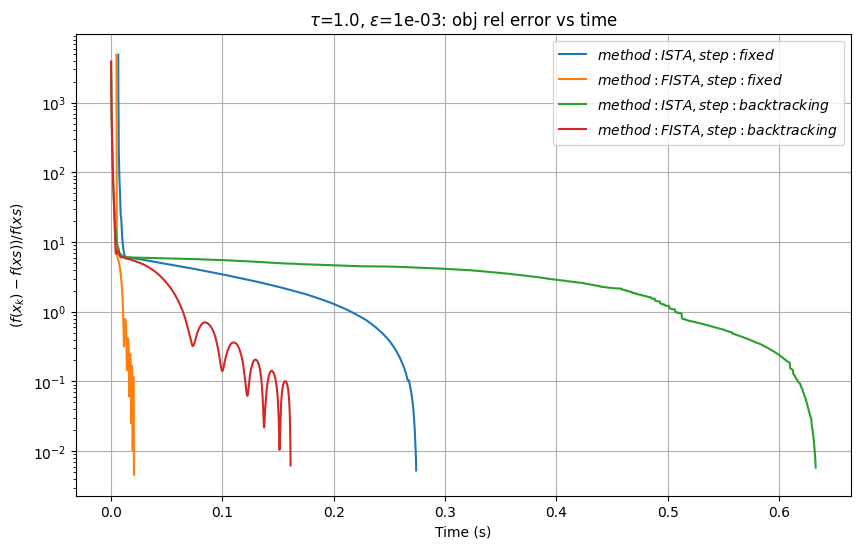

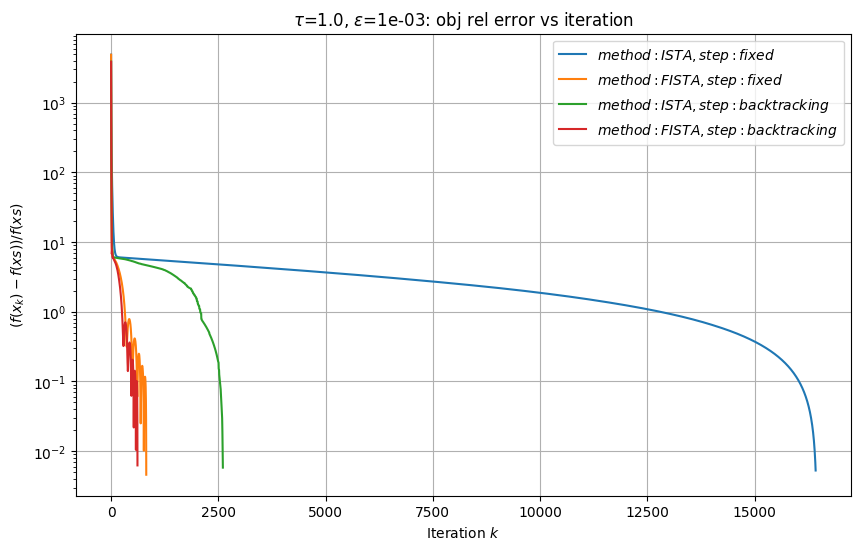

In [18]:
x0 = np.zeros((n, 1))

tau = 1
eps = 1e-3
params = [
          (IstaMethodEnum.STANDARD, StepMethodEnum.FIXED),
          (IstaMethodEnum.FAST, StepMethodEnum.FIXED),
          (IstaMethodEnum.STANDARD, StepMethodEnum.BACKTRACKING),
          (IstaMethodEnum.FAST, StepMethodEnum.BACKTRACKING),
         ]
run_ista_grid_and_plot(A, b, x0, xs, params, tau, eps)